In [1]:
import numpy as np
import matplotlib
from matplotlib import rc
import matplotlib.pyplot as plt
import matplotlib.patches
import time
from matplotlib.ticker import MaxNLocator
import os, sys
from astropy.io import fits
from astropy.stats import sigma_clip
from photutils import aperture_photometry
from photutils import CircularAperture
from numpy import std
import glob
import csv
import operator
import warnings
import matplotlib.ticker as mtick
from photutils.datasets import make_4gaussians_image

In [2]:
def get_stacks(stackpath, basepath, AOR_snip, ch):
    '''
    Find paths to all the fits files.

    Parameters
    ----------


    Returns
    -------

    :return: 
    '''
    stacks = np.array(os.listdir(stackpath))
    locs = np.array([stacks[i].find('SPITZER_I') for i in range(len(stacks))])
    good = np.where(locs!=-1)[0] #filter out all files that don't fit the correct naming convention for correction stacks
    offset = 11 #legth of the string "SPITZER_I#_"
    keys = np.array([stacks[i][locs[i]+offset:].split('_')[0] for i in good]) #pull out just the key that says what sdark this stack is for

    datapath = basepath+'data/'+ch

    data_list = os.listdir(datapath)
    AOR_list = [a for a in data_list if AOR_snip in a]
    calFiles = []
    for i in range(len(AOR_list)):
        path = datapath + '/' + AOR_list[i] + '/' + ch +'/cal/'
        if not os.path.isdir(path):
            print('Error: Folder \''+path+'\' does not exist, so automatic correction stack selection cannot be performed')
            return []
        fname = glob.glob(path+'*sdark.fits')[0]
        loc = fname.find('SPITZER_I')+offset
        key = fname[loc:].split('_')[0]
        calFiles.append(os.path.join(stackpath, stacks[list(good)][np.where(keys == key)[0][0]]))
    return calFiles



def sigma_clipping(image_data, bounds = ( 14, 18, 14, 18)):#,fname):
    global tossed
    lbx, ubx, lby, uby = bounds
    h, w, l = image_data.shape
    # mask invalids
    image_data2 = np.ma.masked_invalid(image_data)
    # make mask to mask entire bad frame
    x = np.ones(shape = (w, l))
    mask = np.ma.make_mask(x)
    sig_clipped_data = sigma_clip(image_data2, sigma=4, maxiters=4, cenfunc=np.ma.median, axis = 0)
    for i in range (h):
        oldstar = image_data[i, lbx:ubx, lby:uby]
        newstar = sig_clipped_data[i, lbx:ubx, lby:uby]
        truth   = newstar==oldstar
        if(np.ma.sum(truth) < truth.size):
            sig_clipped_data[i,:,:] = np.ma.masked_array(sig_clipped_data[i,:,:], mask = mask)
            tossed += 1
            print('tossed:', tossed)
    return sig_clipped_data

def bgsubtract(image_data):
    bgsubimg=image_data
    x=np.ndarray ( shape=(64,32,32), dtype=bool)
    xmask=np.ma.make_mask(x,copy=True, shrink=True, dtype=np.bool)
    xmask[:,:,:]= False
    xmask[:,14:18,14:18]=True
    masked= np.ma.masked_array(bgsubimg, mask=xmask)
    n=0
    #Background subtraction for each frame
    while(n<64):
        bg_avg=np.ma.median(masked[n])
        bgsubimg[n]= bgsubimg[n,:,:] - bg_avg
        n+=1
    return bgsubimg

def centroid_FWM(image_data, scale = 1, bounds = (14, 18, 14, 18)):
    lbx, ubx, lby, uby = bounds
    lbx, ubx, lby, uby = lbx*scale, ubx*scale, lby*scale, uby*scale
    starbox = image_data[:, lbx:ubx, lby:uby]
    h, w, l = starbox.shape
    # get centroid  
    X, Y    = np.mgrid[:w,:l]
    cx      = (np.ma.sum(np.ma.sum(X*starbox, axis=1), axis=1)/(np.ma.sum(np.ma.sum(starbox, axis=1), axis=1))) + lbx
    cy      = (np.ma.sum(np.ma.sum(Y*starbox, axis=1), axis=1)/(np.ma.sum(np.ma.sum(starbox, axis=1), axis=1))) + lby
    # get PSF widths
    X, Y    = np.repeat(X[np.newaxis,:,:], h, axis=0), np.repeat(Y[np.newaxis,:,:], h, axis=0)
    cx, cy  = np.reshape(cx, (h, 1, 1)), np.reshape(cy, (h, 1, 1))
    X2, Y2  = (X + lbx - cx)**2, (Y + lby - cy)**2
    widx    = np.ma.sqrt(np.ma.sum(np.ma.sum(X2*starbox, axis=1), axis=1)/(np.ma.sum(np.ma.sum(starbox, axis=1), axis=1)))
    widy    = np.ma.sqrt(np.ma.sum(np.ma.sum(Y2*starbox, axis=1), axis=1)/(np.ma.sum(np.ma.sum(starbox, axis=1), axis=1)))
    return cx.ravel(), cy.ravel(), widx.ravel(), widy.ravel()

def A_photometry(image_data, factor = 0.029691810510039204,
    cx = 15, cy = 15, r = 2.5, a = 5, b = 5, w_r = 5, h_r = 5, 
    theta = 0, shape = 'Circular', method='center'):
    l, h, w = image_data.shape
    position= [cx, cy]
    ape_sum = []
    if   (shape == 'Circular'):
        aperture = CircularAperture(position, r=r)
    elif (shape == 'Elliptical'):
        aperture = EllipticalAperture(position, a=a, b=b, theta=theta)
    elif (shape == 'Rectangular'):
        aperture = RectangularAperture(position, w=w_r, h=h_r, theta=theta)
    for i in range(l):
        phot_table = aperture_photometry(image_data[i,:,:], aperture)
        ape_sum.extend(phot_table['aperture_sum']*factor)
    return ape_sum


# Noise pixel param
def noisepixparam(image_data,edg):
    lb= 14
    ub= 18
    npp=[]
    # Its better to operate on the copy of desired portion of image_data than on image_data itself.
    # This reduces the risk of modifying image_data accidently. Arguements are passed as pass-by-object-reference.
    stx=np.ndarray((64,4,4))
    
    np.copyto(stx,image_data[:,lb:ub,lb:ub])
    for img in stx:
        #To find noise pixel parameter for each frame. For eqn, refer Knutson et al. 2012
        numer= np.ma.sum(img)
        numer=np.square(numer)
        denom=0.0
        temp = np.square(img)
        denom = np.ma.sum(img)
        param= numer/denom
        npp.append(param)
    return npp  

def bgnormalize(image_data,normbg):
    x=np.ndarray( shape=(64,32,32))
    xmask=np.ma.make_mask(x,copy=True, shrink=True)
    xmask[:,:,:]= False
    xmask[:,13:18,13:18]=True
    masked= np.ma.masked_array(image_data, mask=xmask)
    bgsum = np.zeros(64)
    # Replace for loop with one line code
    for i in range (64):
        bgsum[i] = np.ma.mean(masked[i]) #np.ma.mean
    #background average for the datecube
    bgdcbavg= np.ma.median(bgsum)
    #Normalize
    bgsum=bgsum/bgdcbavg
    normbg.append(bgsum)
    
def normstar(ape_sum,normf):
    starmean=np.ma.median(ape_sum)
    ape_sum=ape_sum/starmean
    normf.append(ape_sum)
    
def normxycent(xo,yo,normx,normy):
    xo=xo/np.ma.median(xo)
    yo=yo/np.ma.median(yo)
    normx.append(xo)
    normy.append(yo)

def normpsfwidth(psfwx,psfwy,normpsfwx,normpsfwy):
    psfwx=psfwx/np.ma.median(psfwx)
    psfwy=psfwy/np.ma.median(psfwy)
    normpsfwx.append(psfwx)
    normpsfwy.append(psfwy) 

def normnoisepix(npp,normnpp):
    npp = npp/np.ma.median(npp)
    normnpp.append(npp)

def stackit(normf,normbg,normx,normy,normpsfwx,normpsfwy,normnpp):
    normf=np.ma.median(normf,axis=0)
    normbg=np.ma.median(normbg, axis=0)
    normx=np.ma.median(normx,axis=0)
    normy=np.ma.median(normy,axis=0)
    normpsfwx=np.ma.median(normpsfwx,axis=0)
    normpsfwy=np.ma.median(normpsfwy,axis=0)
    normnpp=np.ma.median(normnpp,axis=0)
    return normf,normbg,normx,normy,normpsfwx,normpsfwy,normnpp
 
def plotcurve(xax,f,b,X,Y,wx,wy,npp,direc,ct, f_med, f_std, b_med, b_std, x_med, x_std, y_med, y_std, xw_med, xw_std, yw_med, yw_std, npp_med, npp_std, savepath, channel):
    devfactor=2
    fmed=np.ma.median(f)
    fstdev=np.ma.std(f)
    lb=fmed-devfactor*fstdev
    ub=fmed+devfactor*fstdev
    avoid=[]
    i=0
    for x in (0,57):
        if( f[x] <=lb or f[x]>=ub):
            avoid.append(x)
    print (avoid)
    fig, axes = plt.subplots(nrows=7, ncols=1, sharex=True)
    fig.set_figheight(8)
    plt.minorticks_on()
    fig.subplots_adjust(hspace = 0.001)
    plt.rc('font', family='serif')
    
    plt.xlim(0,64)
    y_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
    if 0 not in (avoid):
        axes[0].plot(xax,f,color='k', mec ='b', marker='s', markevery=[0],fillstyle='none')
    if 57 not in (avoid):
        axes[0].plot(xax,f,color='k', mec ='b', marker='s', markevery=[57],fillstyle='none')

    axes[0].plot(xax,f,color='k', mec ='b', marker='s', markevery=[0],fillstyle='none')
    axes[0].set_ylabel(r'$F$',fontsize=16)
    axes[0].yaxis.set_major_formatter(y_formatter)
    axes[0].yaxis.set_major_locator(MaxNLocator(prune='both',nbins=5))
    axes[0].axhline(y = f_med, color='black', linewidth = 1, label = 'Median')
    axes[0].axhline(y = f_med - f_std, color='black', linewidth = 1, label = '$2 \sigma$', alpha = 0.3)
    axes[0].axhline(y = f_med + f_std, color='black', linewidth = 1, label = '$2 \sigma$', alpha = 0.3)

    bmed=np.ma.median(b)
    bstdev=np.ma.std(b)    
    blb=bmed-devfactor*bstdev
    bub=bmed+devfactor*bstdev

    axes[1].plot(xax,b,color='k', mec ='b', marker='s', markevery=[57],fillstyle='none')
    axes[1].plot(xax,b,color='k', mec ='b', marker='s', markevery=[0],fillstyle='none')
    axes[1].set_ylabel(r'$b$',fontsize=16)
    axes[1].yaxis.set_major_formatter(y_formatter)
    axes[1].yaxis.set_major_locator(MaxNLocator(prune='both',nbins=5))
    axes[1].axhline(y = b_med, color='black', linewidth = 1, label = 'Median')
    axes[1].axhline(y = b_med - b_std, color='black', linewidth = 1, label = '$2 \sigma$', alpha = 0.3)
    axes[1].axhline(y = b_med + b_std, color='black', linewidth = 1, label = '$2 \sigma$', alpha = 0.3)

    axes[2].plot(xax,X,color='k', mec ='b',marker='s', markevery=[57],fillstyle='none')
    axes[2].plot(xax,X,color='k', mec ='b',marker='s', markevery=[0],fillstyle='none')
    axes[2].set_ylabel(r'$x_0$',fontsize=16)
    axes[2].yaxis.set_major_formatter(y_formatter)
    axes[2].yaxis.set_major_locator(MaxNLocator(prune='both',nbins=5))
    axes[2].axhline(y = x_med, color='black', linewidth = 1, label = 'Median')
    axes[2].axhline(y = x_med - x_std, color='black', linewidth = 1, label = '$2 \sigma$', alpha = 0.3)
    axes[2].axhline(y = x_med + x_std, color='black', linewidth = 1, label = '$2 \sigma$', alpha = 0.3)

    axes[3].plot(xax,Y,color='k' , mec ='b', marker='s', markevery=[57],fillstyle='none')
    axes[3].plot(xax,Y,color='k' , mec ='b', marker='s', markevery=[0],fillstyle='none')    
    axes[3].set_ylabel(r'$y_0$',fontsize=16)
    axes[3].yaxis.set_major_formatter(y_formatter)
    axes[3].yaxis.set_major_locator(MaxNLocator(prune='both',nbins=5))
    axes[3].axhline(y = y_med, color='black', linewidth = 1, label = 'Median')
    axes[3].axhline(y = y_med - y_std, color='black', linewidth = 1, label = '$2 \sigma$', alpha = 0.3)
    axes[3].axhline(y = y_med + y_std, color='black', linewidth = 1, label = '$2 \sigma$', alpha = 0.3)

    axes[4].plot(xax,wx,color='k' , mec ='b', marker='s', markevery=[57],fillstyle='none')
    axes[4].plot(xax,wx,color='k' , mec ='b', marker='s', markevery=[0], fillstyle='none')
    axes[4].set_ylabel(r'$\sigma_x$',fontsize=16)
    axes[4].yaxis.set_major_formatter(y_formatter)
    axes[4].yaxis.set_major_locator(MaxNLocator(prune='both',nbins=5))
    axes[4].axhline(y = xw_med, color='black', linewidth = 1, label = 'Median')
    axes[4].axhline(y = xw_med - xw_std, color='black', linewidth = 1, label = '$2 \sigma$', alpha = 0.3)
    axes[4].axhline(y = xw_med + xw_std, color='black', linewidth = 1, label = '$2 \sigma$', alpha = 0.3)

    axes[5].plot(xax,wy,color='k' , mec ='b', marker='s', markevery=[57],fillstyle='none')
    axes[5].plot(xax,wy,color='k' , mec ='b', marker='s', markevery=[0],fillstyle='none')
    axes[5].set_ylabel(r'$\sigma_y$', fontsize=16)
    axes[5].yaxis.set_major_formatter(y_formatter)
    axes[5].yaxis.set_major_locator(MaxNLocator(prune='both',nbins=5))
    axes[5].axhline(y = yw_med, color='black', linewidth = 1, label = 'Median')
    axes[5].axhline(y = yw_med - yw_std, color='black', linewidth = 1, label = '$2 \sigma$', alpha = 0.3)
    axes[5].axhline(y = yw_med + yw_std, color='black', linewidth = 1, label = '$2 \sigma$', alpha = 0.3)    

    axes[6].plot(xax,npp,color='k' , mec ='b', marker='s', markevery=[57],fillstyle='none')
    axes[6].plot(xax,npp,color='k' , mec ='b', marker='s', markevery=[0],fillstyle='none')
    axes[6].set_ylabel(r'$\beta$', fontsize=16)
    axes[6].set_xlabel('Frame number',fontsize=16)
    axes[6].yaxis.set_major_formatter(y_formatter)
    axes[6].yaxis.set_major_locator(MaxNLocator(prune='both',nbins=5))
    axes[6].axhline(y = npp_med, color='black', linewidth = 1, label = 'Median')
    axes[6].axhline(y = npp_med - npp_std, color='black', linewidth = 1, label = '$2 \sigma$', alpha = 0.3)
    axes[6].axhline(y = npp_med + npp_std, color='black', linewidth = 1, label = '$2 \sigma$', alpha = 0.3)
    axes[6].set_xlim((-0.5, 63.5))

    if channel == 'ch1':
        wav='3.6'
    else:
        wav='4.5'
    plt.savefig(savepath+wav+'_' +str(ct)+'_' +direc+'.pdf', bbox_inches='tight', dpi=200)

In [3]:
#####################################################################
#Only these values need to be personalized

planet = 'WASP121b' #planet name
channel = 'ch1'         #Spitzer IRAC channel
AOR_snip = 'r6497'         #bit of AOR to pick out which folders contain AORs that should be analyzed
basepath = '/home/taylor/Documents/Research/spitzer/'+planet+'/'  #folder containing data to be analyzed
savepath = basepath+'analysis/frameDiagnostics/'
stackpath = '/home/taylor/Documents/Research/spitzer/Calibration/' #folder containing properly names correction stacks (will be automatically selected)
addStack = False        #do you want to add a correction stack to fix bad backgrounds

#####################################################################

['r64973568', 'r64974080', 'r64973056', 'r64975104']
r64973568
/home/taylor/Documents/Research/spitzer/WASP121b/data/ch1/r64973568/ch1/bcd
tossed: 1
tossed: 2


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 3


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 4


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 5
tossed: 6


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 7
tossed: 8


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 9


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 10


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 11
tossed: 12


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 13
tossed: 14


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 15
tossed: 16


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 17
tossed: 18


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 19
tossed: 20


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 21
tossed: 22
tossed: 23


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 24
tossed: 25
tossed: 26


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 27
tossed: 28


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 29


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 30
tossed: 31


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 32
tossed: 33


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.


tossed: 34


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 35


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 36


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 37
tossed: 38
tossed: 39
tossed: 40


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 41
tossed: 42


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 43
tossed: 44


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 45
tossed: 46


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 47
tossed: 48


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 49


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 50


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 51


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 52


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 53
tossed: 54


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 55


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 56


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 57
tossed: 58


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 59
tossed: 60


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 61
tossed: 62
tossed: 63


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 64
tossed: 65


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 66
tossed: 67
tossed: 68


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 69


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 70


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 71


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 72


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 73
tossed: 74


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 75
tossed: 76


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 77
tossed: 78


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 79


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 80


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 81
tossed: 82


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 83
tossed: 84


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 85


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 86
tossed: 87
tossed: 88


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 89


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 90
tossed: 91


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 92


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 93


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 94
tossed: 95


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  apert

tossed: 96
tossed: 97


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 98


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 99


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 100


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 101
tossed: 102


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 103


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 104


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 105


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 106
tossed: 107


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 108
tossed: 109


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 110


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 111


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 112


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 113


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 114


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 115
tossed: 116


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 117
tossed: 118


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 119
tossed: 120


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 121
tossed: 122


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 123
tossed: 124


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 125
tossed: 126


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 127


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 128


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 129
tossed: 130


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 131


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 132
tossed: 133


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 134


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 135
tossed: 136
tossed: 137


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 138
tossed: 139


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 140
tossed: 141


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 142


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 143


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 144
tossed: 145


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 146


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 147


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 148


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 149


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 150


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 151


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 152
tossed: 153


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 154


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 155
tossed: 156


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 157


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 158


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 159
tossed: 160
tossed: 161


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 162


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 163
tossed: 164


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 165


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 166


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 167


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 168


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 169
tossed: 170
tossed: 171


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 172


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 173


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 174


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


[]


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


[]
r64974080
/home/taylor/Documents/Research/spitzer/WASP121b/data/ch1/r64974080/ch1/bcd
tossed: 175
tossed: 176


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 177


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 178


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 179


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 180


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 181


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 182


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 183


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 184


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 185
tossed: 186
tossed: 187
tossed: 188


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 189


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 190
tossed: 191
tossed: 192


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.


tossed: 193


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warni

tossed: 194
tossed: 195
tossed: 196


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 197
tossed: 198


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 199


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 200


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 201


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 202


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 203


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 204
tossed: 205


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.


tossed: 206


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 207


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


[]


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


[]
r64973056
/home/taylor/Documents/Research/spitzer/WASP121b/data/ch1/r64973056/ch1/bcd
tossed: 208


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 209


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 210
tossed: 211


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 212


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 213


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 214


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 215


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 216


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 217
tossed: 218


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 219


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 220


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 221


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 222


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 223


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 224


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 225


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 226
tossed: 227


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 228
tossed: 229


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 230
tossed: 231


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 232


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 233


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 234
tossed: 235


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 236
tossed: 237


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  apert

tossed: 238
tossed: 239


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 240
tossed: 241


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 242


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 243
tossed: 244
tossed: 245


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 246


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 247
tossed: 248
tossed: 249


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 250


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 251


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 252


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 253
tossed: 254


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 255


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 256
tossed: 257


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 258


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 259
tossed: 260


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.


tossed: 261


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 262


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 263


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 264


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 265
tossed: 266


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 267
tossed: 268


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 269
tossed: 270


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 271
tossed: 272


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 273


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 274


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 275


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 276
tossed: 277


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 278
tossed: 279


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 280


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 281
tossed: 282


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  apert

tossed: 283
tossed: 284
tossed: 285
tossed: 286


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 287
tossed: 288


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 289


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 290


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 291
tossed: 292


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 293


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 294


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 295


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 296
tossed: 297


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 298


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 299
[]


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


[]
r64975104
/home/taylor/Documents/Research/spitzer/WASP121b/data/ch1/r64975104/ch1/bcd
tossed: 300
tossed: 301


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  apert

tossed: 302
tossed: 303


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 304


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 305
tossed: 306


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 307


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 308


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 309


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 310


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 311


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 312


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 313
tossed: 314


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 315
tossed: 316
tossed: 317


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 318


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 319


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 320


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 321
tossed: 322


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 323
tossed: 324
tossed: 325


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 326


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 327


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 328


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 329


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 330


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 331


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 332


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 333


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 334
tossed: 335


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 336


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 337


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 338


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 339


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 340


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 341


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 342
tossed: 343


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 344


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 345


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 346


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 347


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 348


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 349


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 350
tossed: 351


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 352


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 353
tossed: 354


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 355


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 356
tossed: 357


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 358


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 359


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 360


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 361


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 362


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 363
tossed: 364


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.


tossed: 365
tossed: 366


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.


tossed: 367
tossed: 368


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 369


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 370


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 371
tossed: 372


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 373


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 374


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


tossed: 375


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:138: UserWarning: Warning: converting a masked element to nan.
/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/photutils/aperture/core.py:356: UserWarning: Warning: converting a masked element to nan.
  aperture_sums = np.array(aperture_sums)


[]


/home/taylor/anaconda3/envs/python3/lib/python3.6/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


[]


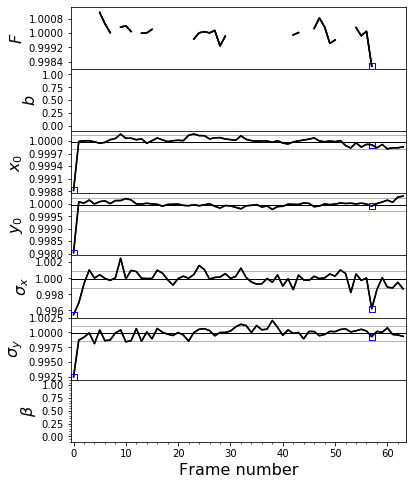

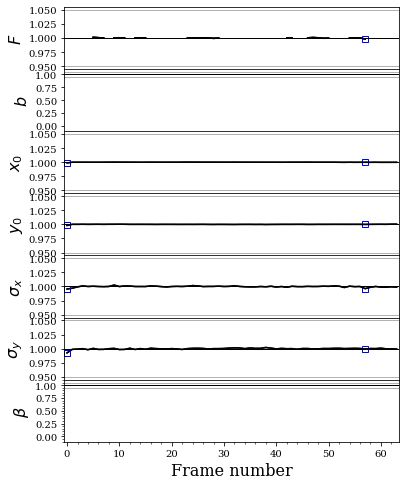

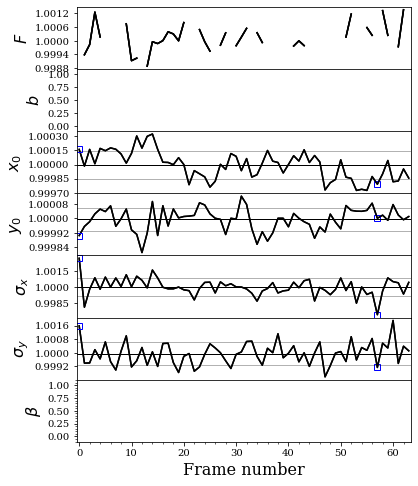

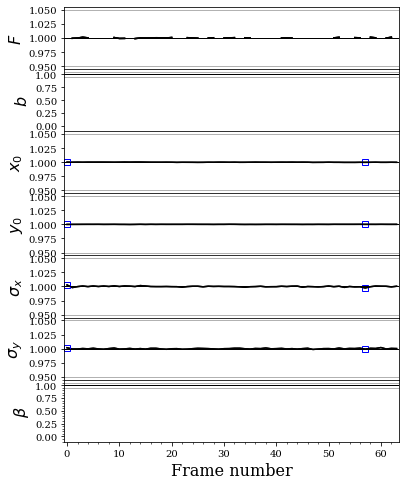

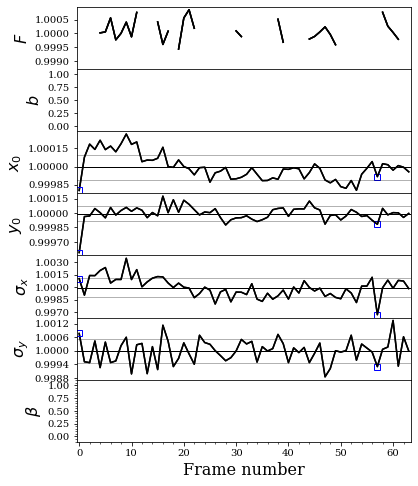

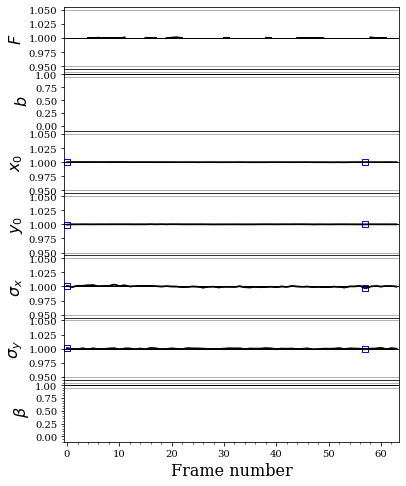

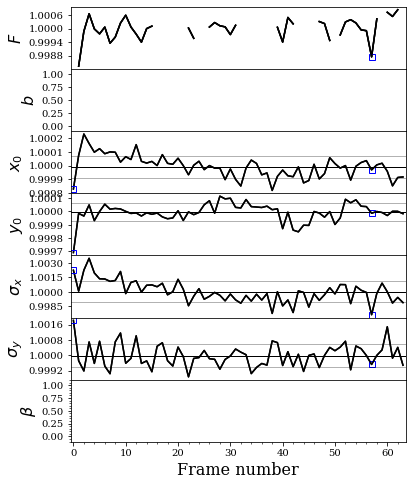

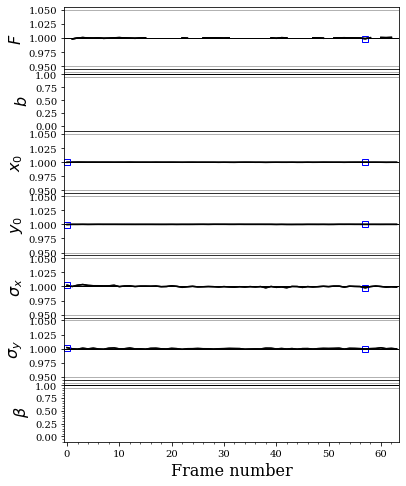

In [4]:
if addStack:
    stacks = get_stacks(stackpath, basepath, AOR_snip, channel)
    savepath += channel+'/addedStack/'
else:
    savepath += channel+'/addedBlank/'

outerpath = basepath+'data/'+channel+'/'
dirs_all = os.listdir(outerpath)
dirs = [k for k in dirs_all if AOR_snip in k]
print (dirs)
tossed = 0
counter=0
ct = 0

for i in range(len(dirs)):

    direc = dirs[i]

    if addStack:
        stack = fits.open(stacks[i], mode='readonly')
        skydark = stack[0].data

    print (direc)
    normbg=[]
    normf=[]
    normx=[]
    normy=[]
    normpsfwx=[]
    normpsfwy=[]
    normnpp=[]
    path = outerpath+direc+'/'+channel+'/bcd'
    print (path)
    for filename in glob.glob(os.path.join(path, '*bcd.fits')):
        #print filename
        f=fits.open(filename,mode='readonly')
        # get data and apply sky dark correction
        image_data0 = f[0].data
        if addStack:
            image_data0 += skydark
        # convert MJy/str to electron count
        convfact=f[0].header['GAIN']*f[0].header['EXPTIME']/f[0].header['FLUXCONV']
        image_data1=image_data0*convfact        
        #sigma clip
        image_data2=sigma_clipping(image_data1)
        #b should be calculated on sigmaclipped data
        bgnormalize(image_data2,normbg)
        #bg subtract
        image_data3=bgsubtract(image_data2)
        #centroid
        xo, yo, psfwx,psfwy = centroid_FWM(image_data3) # xo, yo, psxfwx, psfwy are temp
        ape_sum = A_photometry(np.ma.masked_invalid(image_data3))
        npp=noisepixparam(image_data3,4)        
        normstar(np.ma.masked_invalid(ape_sum),normf)
        normxycent(xo,yo,normx,normy)
        normpsfwidth(psfwx,psfwy,normpsfwx,normpsfwy)
        normnoisepix(npp,normnpp)
        ct+=1
    counter+=1
    
    pathFULL  = savepath
    pathflux  = pathFULL + 'flux' + direc
    pathbg    = pathFULL + 'bg' + direc
    pathx     = pathFULL + 'xdata' + direc
    pathy     = pathFULL + 'ydata' + direc

    pathpsfx  = pathFULL + 'psfwx' + direc
    pathpsfy  = pathFULL + 'psfwy' + direc
    pathbeta  = pathFULL + 'beta' + direc
    np.save(pathflux, normf)
    np.save(pathbg, normbg)
    np.save(pathx, normx)
    np.save(pathy, normy)
    np.save(pathpsfx, normpsfwx)
    np.save(pathpsfy, normpsfwy)
    np.save(pathbeta, normnpp)

    normf,normbg,normx,normy,normpsfwx,normpsfwy,normnpp = stackit(normf,normbg,normx,normy,normpsfwx,normpsfwy,normnpp)

    frameno=np.arange(0,64)
    f_med = np.ma.mean(normf)
    f_std = np.ma.std(normf)
    b_med = np.ma.mean(normbg)
    b_std = np.ma.std(normbg)
    x_med = np.ma.mean(normx)
    x_std = np.ma.std(normx)
    y_med = np.ma.mean(normy)
    y_std = np.ma.std(normy)
    xw_med = np.ma.mean(normpsfwx)
    xw_std = np.ma.std(normpsfwx)
    yw_med = np.ma.mean(normpsfwy)
    yw_std = np.ma.std(normpsfwy)
    npp_med = np.ma.mean(normnpp)
    npp_std = np.ma.std(normnpp)
    plotcurve(frameno,normf,normbg,normx,normy,normpsfwx,normpsfwy,normnpp,'all',ct, f_med, f_std, b_med, b_std, x_med, x_std, y_med, y_std, xw_med, xw_std, yw_med, yw_std, npp_med, npp_std, savepath, channel)
    plotcurve(frameno,normf,normbg,normx,normy,normpsfwx,normpsfwy,normnpp,'all01',ct, 1, 0.05, 1, 0.05, 1, 0.05, 1, 0.05, 1, 0.05, 1, 0.05, 1, 0.05, savepath, channel)
